In [1]:
!pip install opencv-python==4.5.5.62
!pip install opencv-contrib-python==4.5.5.62
!pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.7.0.72
    Uninstalling opencv-contrib-python-4.7.0.72:
      Successfully uninstalled opencv-contrib-python-4.7.0.72
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.1 MB/s eta 0:00:00


In [2]:
import os
import gc
import sys

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import skimage
from skimage.feature import hog, canny
from skimage.filters import sobel
from skimage import color

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
import keras.backend as K
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization, Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from tf_explain.core.activations import ExtractActivations
from tf_explain.core.smoothgrad import SmoothGrad

from PIL import Image
from tqdm import tqdm
import random as rnd
import cv2
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

!pip install livelossplot
from livelossplot import PlotLossesKeras

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
train_path = r'/content/drive/MyDrive/Railway Track fault detection/Train'
val_path = r'/content/drive/MyDrive/Railway Track fault detection/Validation'
test_path = r'/content/drive/MyDrive/Railway Track fault detection/Test'


In [6]:
train_df_defective = pd.DataFrame(os.listdir(train_path+'/Defective'))
val_df_defective = pd.DataFrame(os.listdir(val_path+'/Defective')) 
test_df_defective = pd.DataFrame(os.listdir(test_path+'/Defective')) 
train_df_undefective = pd.DataFrame(os.listdir(train_path+'/Non defective'))
val_df_undefective = pd.DataFrame(os.listdir(val_path+'/Non defective')) 
test_df_undefective = pd.DataFrame(os.listdir(test_path+'/Non defective')) 

In [7]:
defective=pd.concat([train_df_defective,test_df_defective,val_df_defective], axis=0)
undefective=pd.concat([train_df_undefective,test_df_undefective,val_df_undefective], axis=0)

In [8]:
widths, heights = [], []
defective_path_images = []

for path in tqdm(defective[0]):
    try:
        width, height = Image.open(r'/content/drive/MyDrive/Railway Track fault detection/Test/Defective/'+path).size
        widths.append(width)
        heights.append(height)
        defective_path_images.append(r'/content/drive/MyDrive/Railway Track fault detection/Test/Defective/'+path)
    except:
        try:
            width, height = Image.open(r'/content/drive/MyDrive/Railway Track fault detection/Train/Defective/'+path).size
            widths.append(width)
            heights.append(height)
            defective_path_images.append(r'/content/drive/MyDrive/Railway Track fault detection/Train/Defective/'+path)
        except:
            try:
                width, height = Image.open(r'/content/drive/MyDrive/Railway Track fault detection/Validation/Defective/'+path).size
                widths.append(width)
                heights.append(height)
                defective_path_images.append(r'/content/drive/MyDrive/Railway Track fault detection/Validation/Defective/'+path)
            except:
                continue
    
df_defective = pd.DataFrame()
df_defective["width"] = widths
df_defective["height"] = heights
df_defective["path"] = defective_path_images
df_defective["dimension"] = df_defective["width"] * df_defective["height"]

100%|██████████| 187/187 [00:57<00:00,  3.24it/s]


In [9]:
widths, heights = [], []
undefective_path_images = []

for path in tqdm(undefective[0]):
    try:
        width, height = Image.open(r'/content/drive/MyDrive/Railway Track fault detection/Test/Non defective/'+path).size
        widths.append(width)
        heights.append(height)
        undefective_path_images.append(r'/content/drive/MyDrive/Railway Track fault detection/Test/Non defective/'+path)
    except:
        try:
            width, height = Image.open(r'/content/drive/MyDrive/Railway Track fault detection/Train/Non defective/'+path).size
            widths.append(width)
            heights.append(height)
            undefective_path_images.append(r'/content/drive/MyDrive/Railway Track fault detection/Train/Non defective/'+path)
        except:
            try:
                width, height = Image.open(r'/content/drive/MyDrive/Railway Track fault detection/Validation/Non defective/'+path).shape
                print(width)
                widths.append(width)
                heights.append(height)
                undefective_path_images.append(r'/content/drive/MyDrive/Railway Track fault detection/Validation/Non defective/'+path)
            except:
                continue
    
df_undefective = pd.DataFrame()
df_undefective["width"] = widths
df_undefective["height"] = heights
df_undefective["path"] = undefective_path_images
df_undefective["dimension"] = df_undefective["width"] * df_undefective["height"]

100%|██████████| 81/81 [00:26<00:00,  3.08it/s]


In [12]:
def is_grey_scale(givenImage):
    w,h = givenImage.size
    for i in range(w):
        for j in range(h):
            r,g,b = givenImage.getpixel((i,j))
            if r != g != b: return False
    return True
    

In [13]:
def get_rgb_men(row):
    img = cv2.imread(row['path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return np.sum(img[:,:,0]), np.sum(img[:,:,1]), np.sum(img[:,:,2])

tqdm.pandas()
df_defective['R'], df_defective['G'], df_defective['B'] = zip(*df_defective.progress_apply(lambda row: get_rgb_men(row), axis=1) )

100%|██████████| 187/187 [01:01<00:00,  3.06it/s]


In [14]:
def get_rgb_men(row):
    img = cv2.imread(row['path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return np.sum(img[:,:,0]), np.sum(img[:,:,1]), np.sum(img[:,:,2])

tqdm.pandas()
df_undefective['R'], df_undefective['G'], df_undefective['B'] = zip(*df_undefective.progress_apply(lambda row: get_rgb_men(row), axis=1) )

100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


In [18]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/Railway Track fault detection',
    target_size=(448, 448),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42
)

Found 267 images belonging to 3 classes.


In [19]:
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 
resnet50_train = resnet50_datagen.flow_from_directory(
    directory="/content/drive/MyDrive/Railway Track fault detection/Train",
    target_size=(448, 448),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42,
    
)
resnet50_val = resnet50_datagen.flow_from_directory(
    directory="/content/drive/MyDrive/Railway Track fault detection/Train",
    target_size=(448, 448),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42,
)

Found 183 images belonging to 2 classes.
Found 183 images belonging to 2 classes.


In [20]:
resnet50 = ResNet50(include_top = False, input_shape = (448,448,3), weights = 'imagenet')

for layer in resnet50.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet50.output)
predictions = Dense(1, activation='sigmoid')(x)

model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)

94765736/94765736 [==============================] - 1s 0us/step


In [21]:
model_resnet50.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [31]:
history_resnet50 = model_resnet50.fit(resnet50_train,validation_data=resnet50_val,epochs=10,verbose=2)

Epoch 1/10
6/6 - 463s - loss: 0.3645 - accuracy: 0.7978 - val_loss: 0.3378 - val_accuracy: 0.8087 - 463s/epoch - 77s/step
Epoch 2/10
6/6 - 463s - loss: 0.3184 - accuracy: 0.8689 - val_loss: 0.2996 - val_accuracy: 0.9235 - 463s/epoch - 77s/step
Epoch 3/10
6/6 - 406s - loss: 0.2708 - accuracy: 0.9454 - val_loss: 0.2413 - val_accuracy: 0.8907 - 406s/epoch - 68s/step
Epoch 4/10
6/6 - 410s - loss: 0.2438 - accuracy: 0.8907 - val_loss: 0.2339 - val_accuracy: 0.8907 - 410s/epoch - 68s/step
Epoch 5/10
6/6 - 458s - loss: 0.2502 - accuracy: 0.8907 - val_loss: 0.2240 - val_accuracy: 0.9672 - 458s/epoch - 76s/step
Epoch 6/10
6/6 - 398s - loss: 0.2045 - accuracy: 0.9290 - val_loss: 0.1962 - val_accuracy: 0.9290 - 398s/epoch - 66s/step
Epoch 7/10
6/6 - 398s - loss: 0.1884 - accuracy: 0.9399 - val_loss: 0.1833 - val_accuracy: 0.9454 - 398s/epoch - 66s/step
Epoch 8/10
6/6 - 403s - loss: 0.1864 - accuracy: 0.9290 - val_loss: 0.1702 - val_accuracy: 0.9563 - 403s/epoch - 67s/step
Epoch 9/10
6/6 - 395s - 

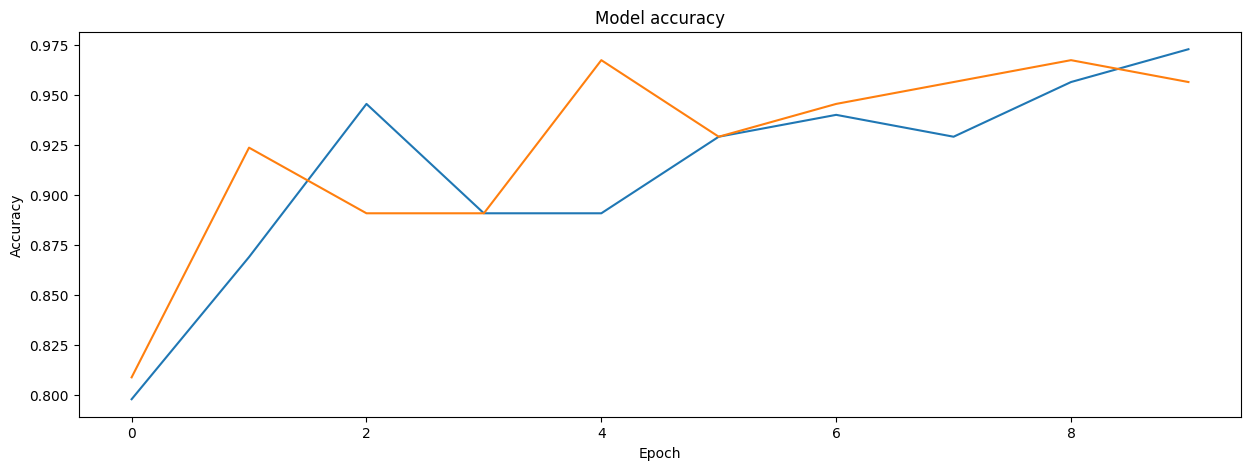

In [32]:
plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()


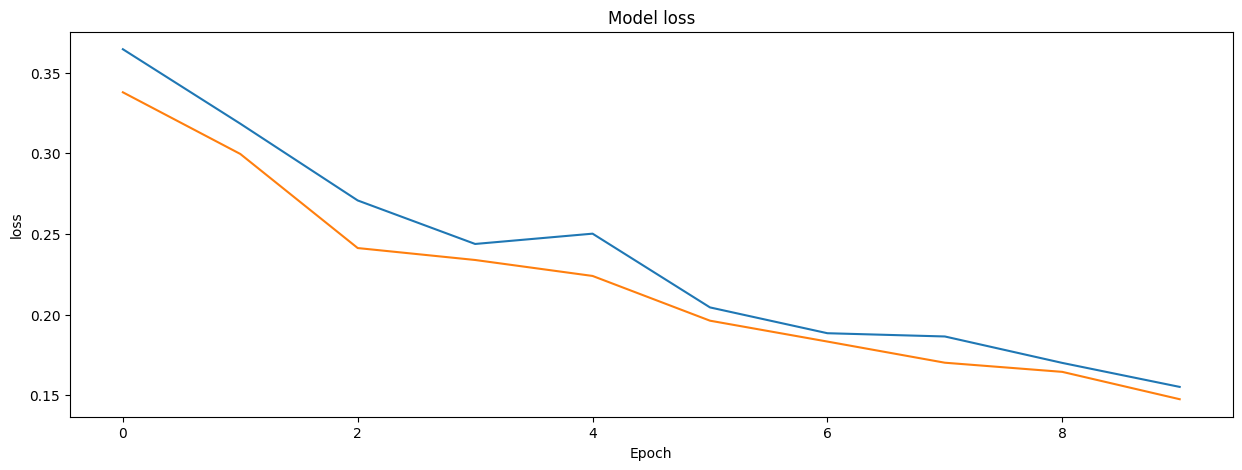

In [33]:
plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()


In [34]:
def gradcam_visualise(data, model, class_index):
    explainer = SmoothGrad()
    output = explainer.explain(data, model, class_index=class_index)
    return output

def activation_visualise(image, model, layers):
    explainer = ExtractActivations()
    output = explainer.explain([image], model, layers_name=layers)
    return output

In [35]:
def plot_data_eight(class_name, outputs):
    fig = plt.figure(figsize=(32, 32))
    plt.suptitle(class_name)
    plt.subplot(4,2,1)
    plt.imshow(outputs[0])
    plt.subplot(4,2,2)
    plt.imshow(outputs[1])
    plt.subplot(4,2,3)
    plt.imshow(outputs[2])
    plt.subplot(4,2,4)
    plt.imshow(outputs[3])
    plt.subplot(4,2,5)
    plt.imshow(outputs[4])
    plt.subplot(4,2,6)
    plt.imshow(outputs[5])
    plt.subplot(4,2,7)
    plt.imshow(outputs[6])
    plt.subplot(4,2,8)
    plt.imshow(outputs[7])
    plt.show()

In [37]:
def grad_cam(model, df_exp, class_name, pre_process_input, class_index):
    output_data = []
    for idx,i in enumerate(np.random.choice(df_exp[0],8)):
        image = cv2.imread('/content/drive/MyDrive/Railway Track fault detection/Test/'+class_name+'/'+i)
        image = cv2.resize(image, (448,448))
        image = pre_process_input(image)
        data = ([image], None)
        output = gradcam_visualise(data, model, class_index)
        output_data.append(output)
    plot_data_eight(class_name, output_data)

In [38]:
def activations_model(model, df_exp, class_name, pre_process_input, layers):
    output_data = []
    for idx,i in enumerate(np.random.choice(df_exp[0],8)):
        image = cv2.imread('/content/drive/MyDrive/Railway Track fault detection/Test/'+class_name+'/'+i)
        image = cv2.resize(image, (448,448))
        image = pre_process_input(image)
        image = tf.expand_dims(image, axis=0)
        output = activation_visualise([image], model, layers)
        output_data.append(output)
    plot_data_eight(class_name, output_data)

In [39]:
from tensorflow.keras.applications.resnet50 import preprocess_input

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(5, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


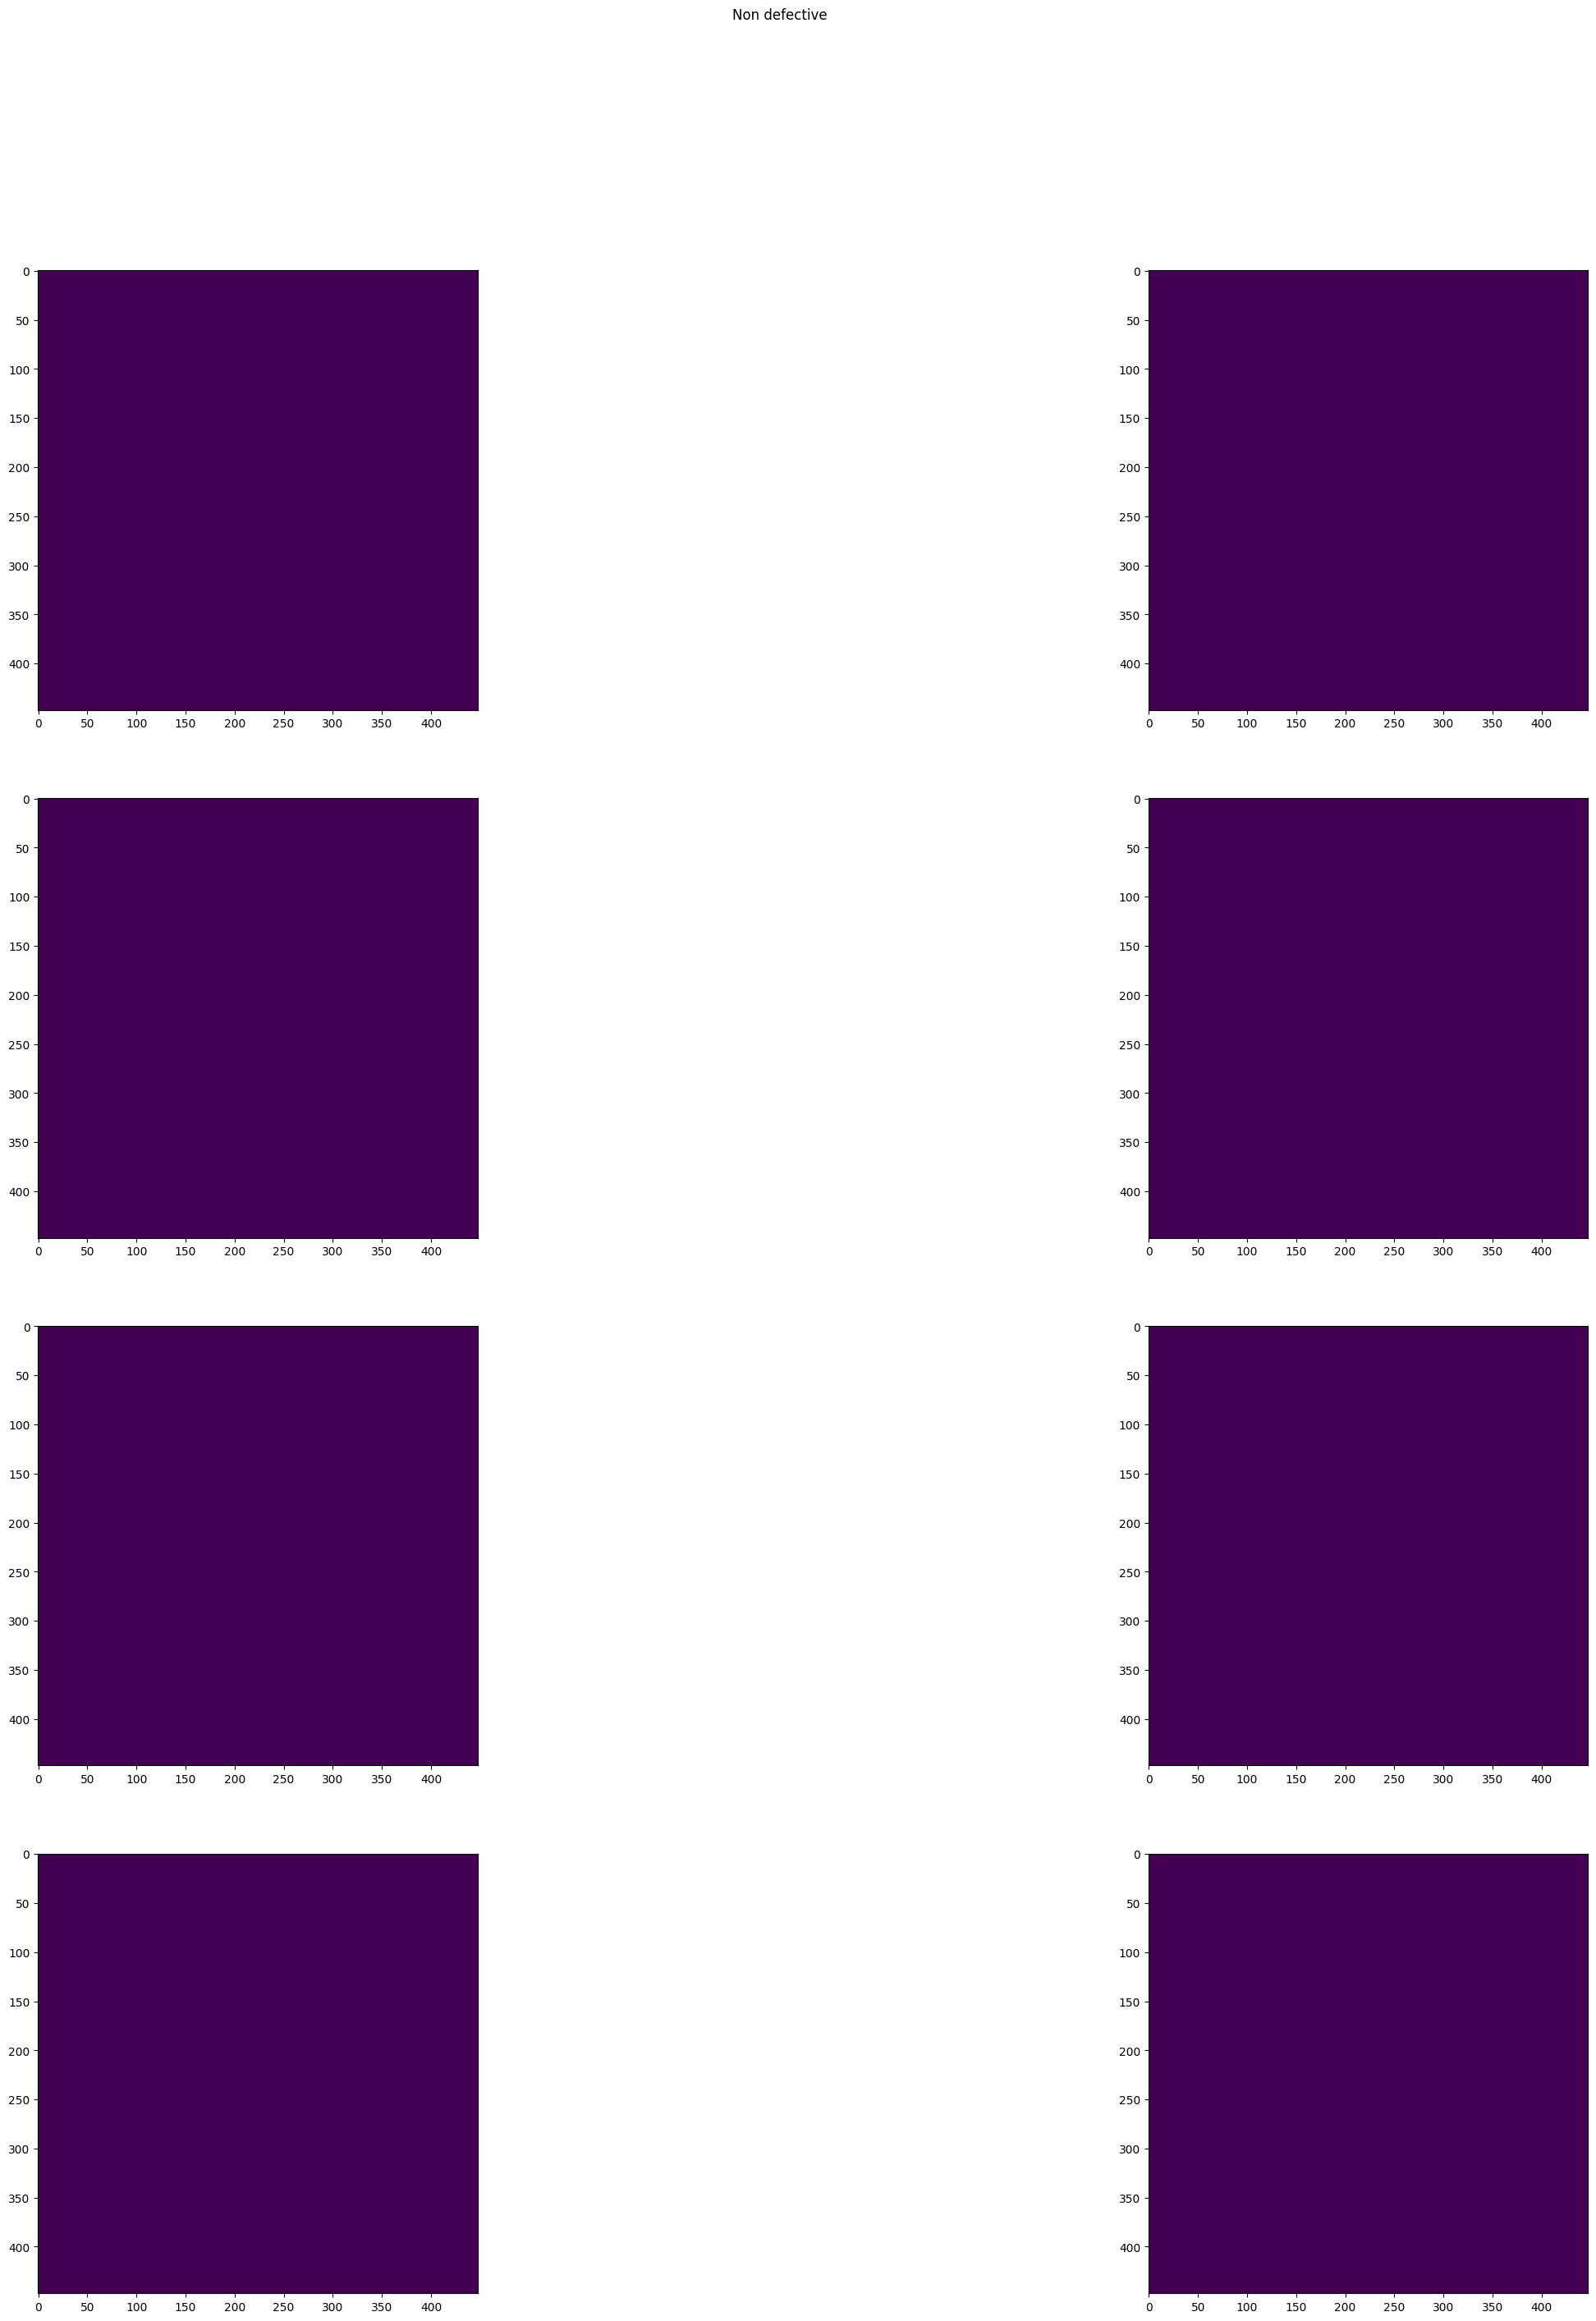

In [40]:
grad_cam(model_resnet50, test_df_undefective, "Non defective", preprocess_input, 0)

In [41]:
grad_cam(model_resnet50, test_df_defective, "Defective", preprocess_input, 1)

Output hidden; open in https://colab.research.google.com to view.

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


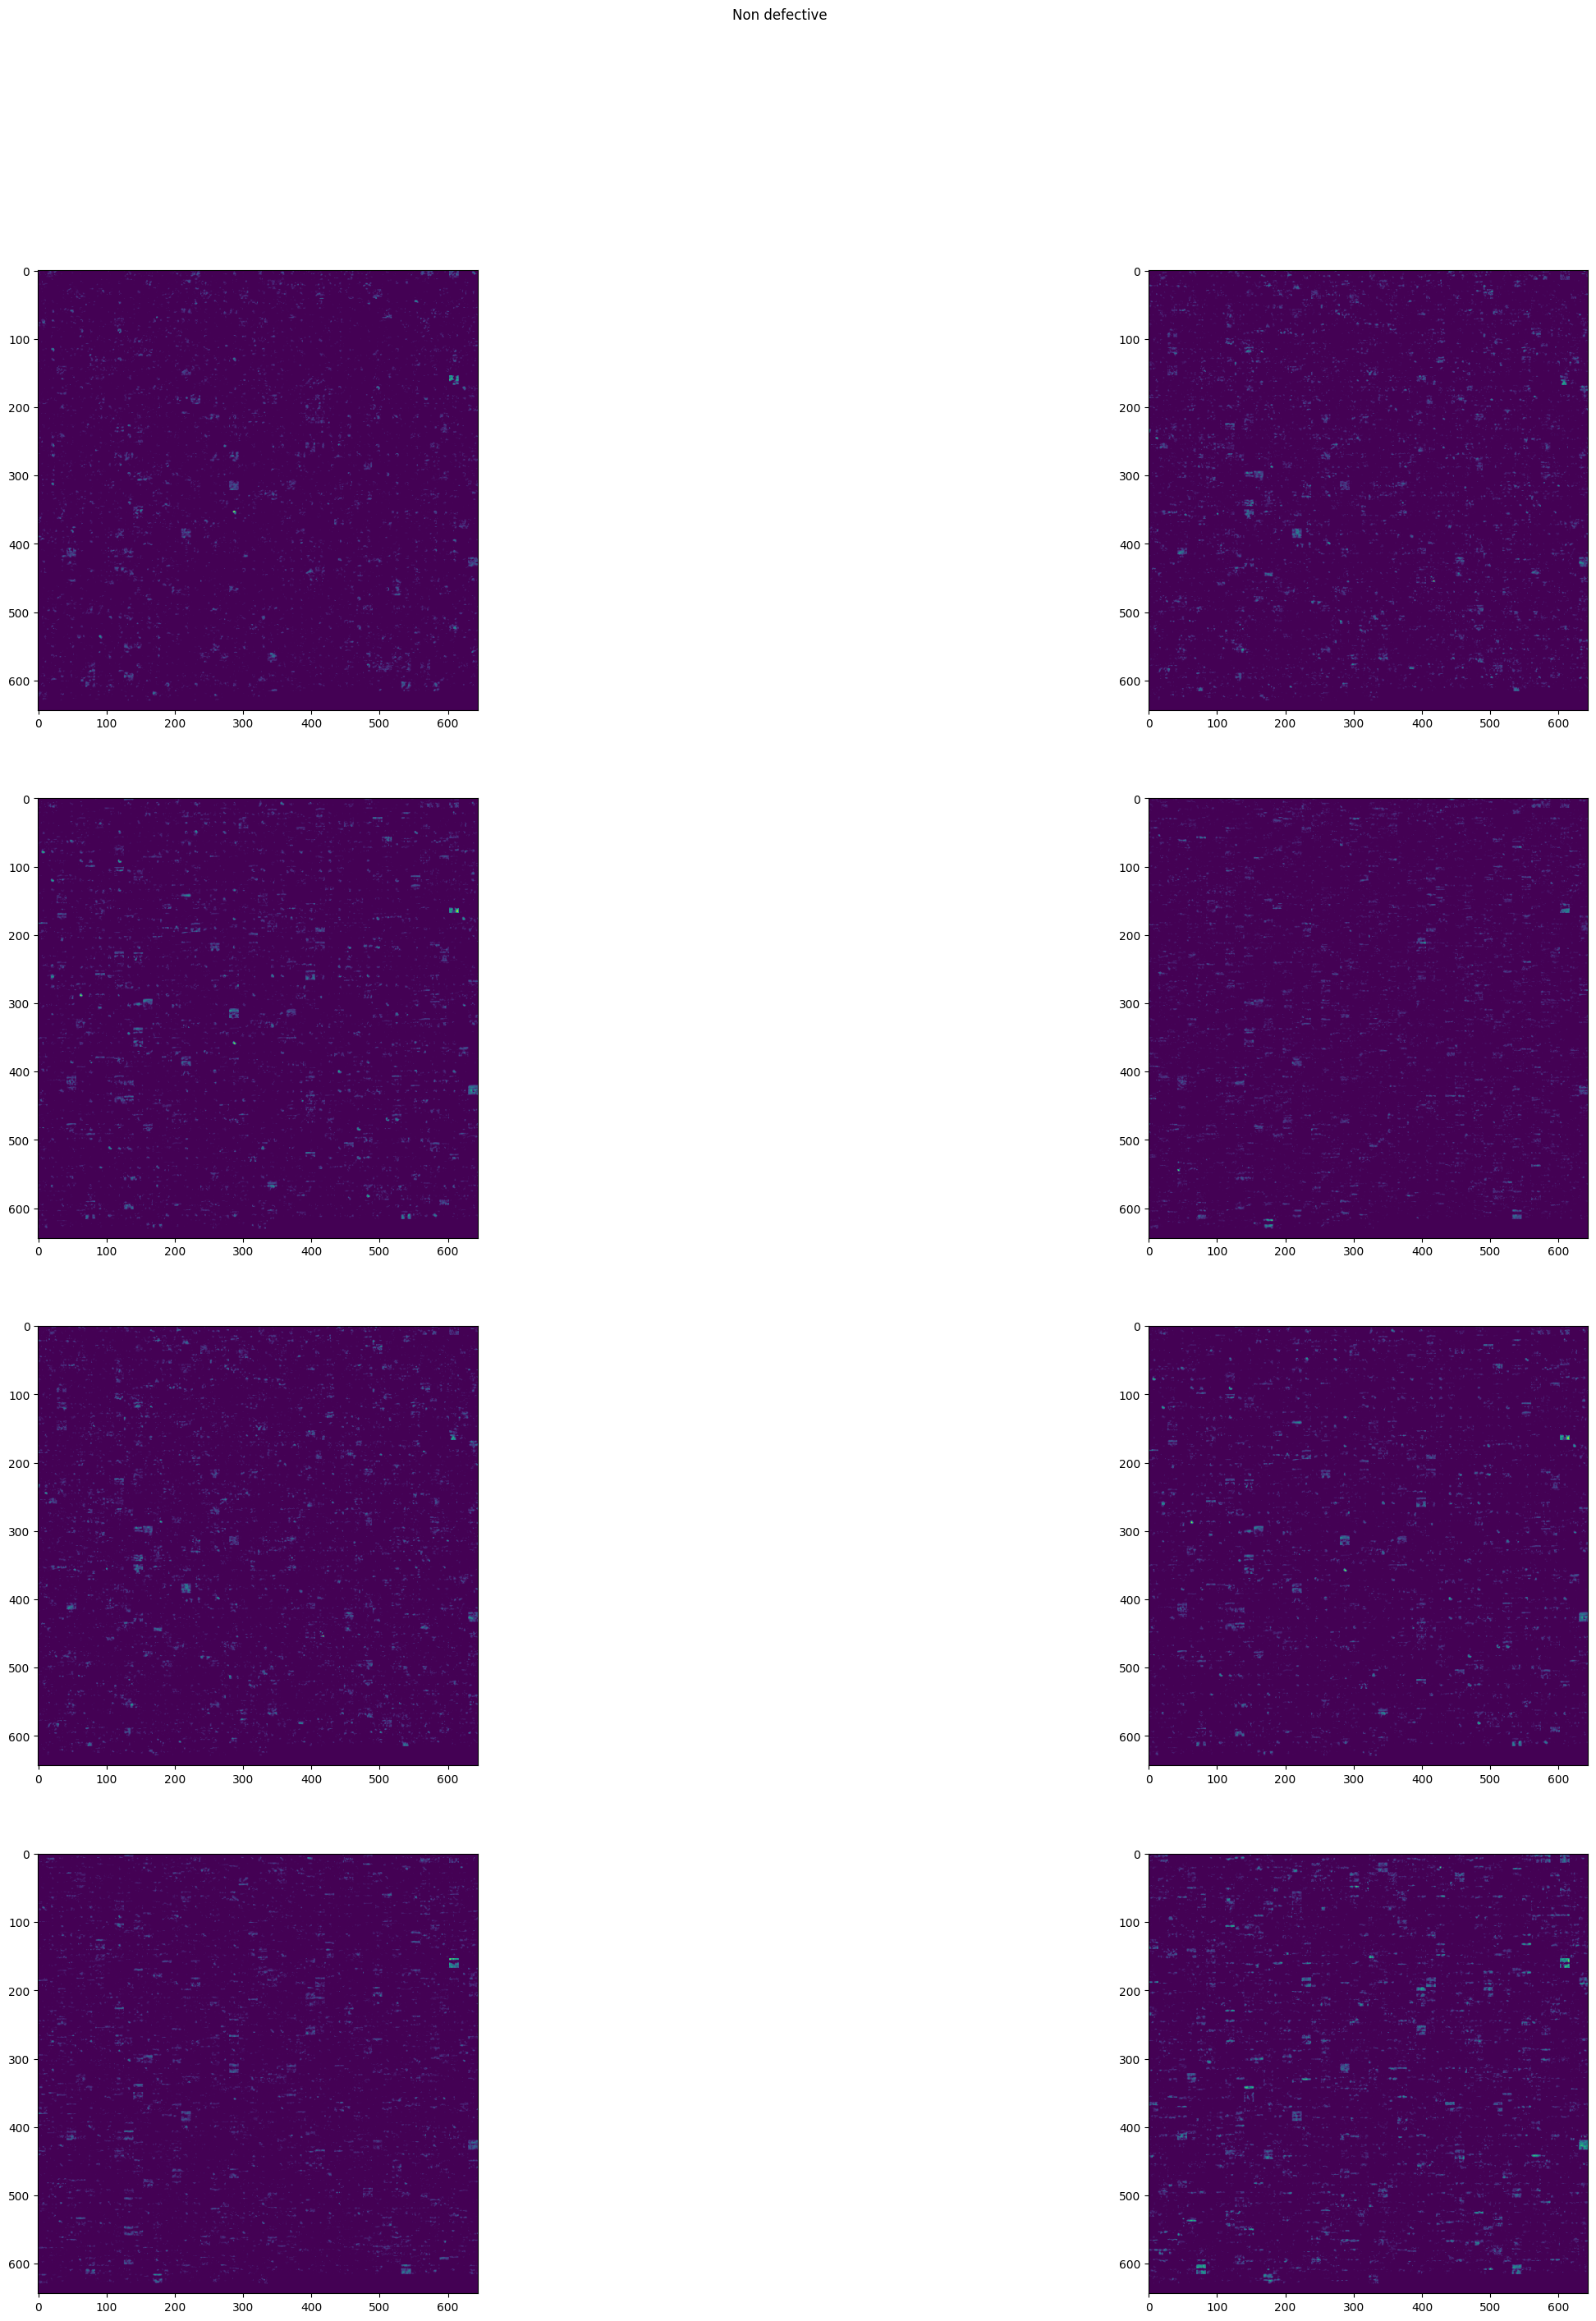

In [42]:
activations_model(model_resnet50, test_df_undefective, "Non defective", preprocess_input, [model_resnet50.layers[-3].name])

1/1 [==============================] - 2s 2s/step


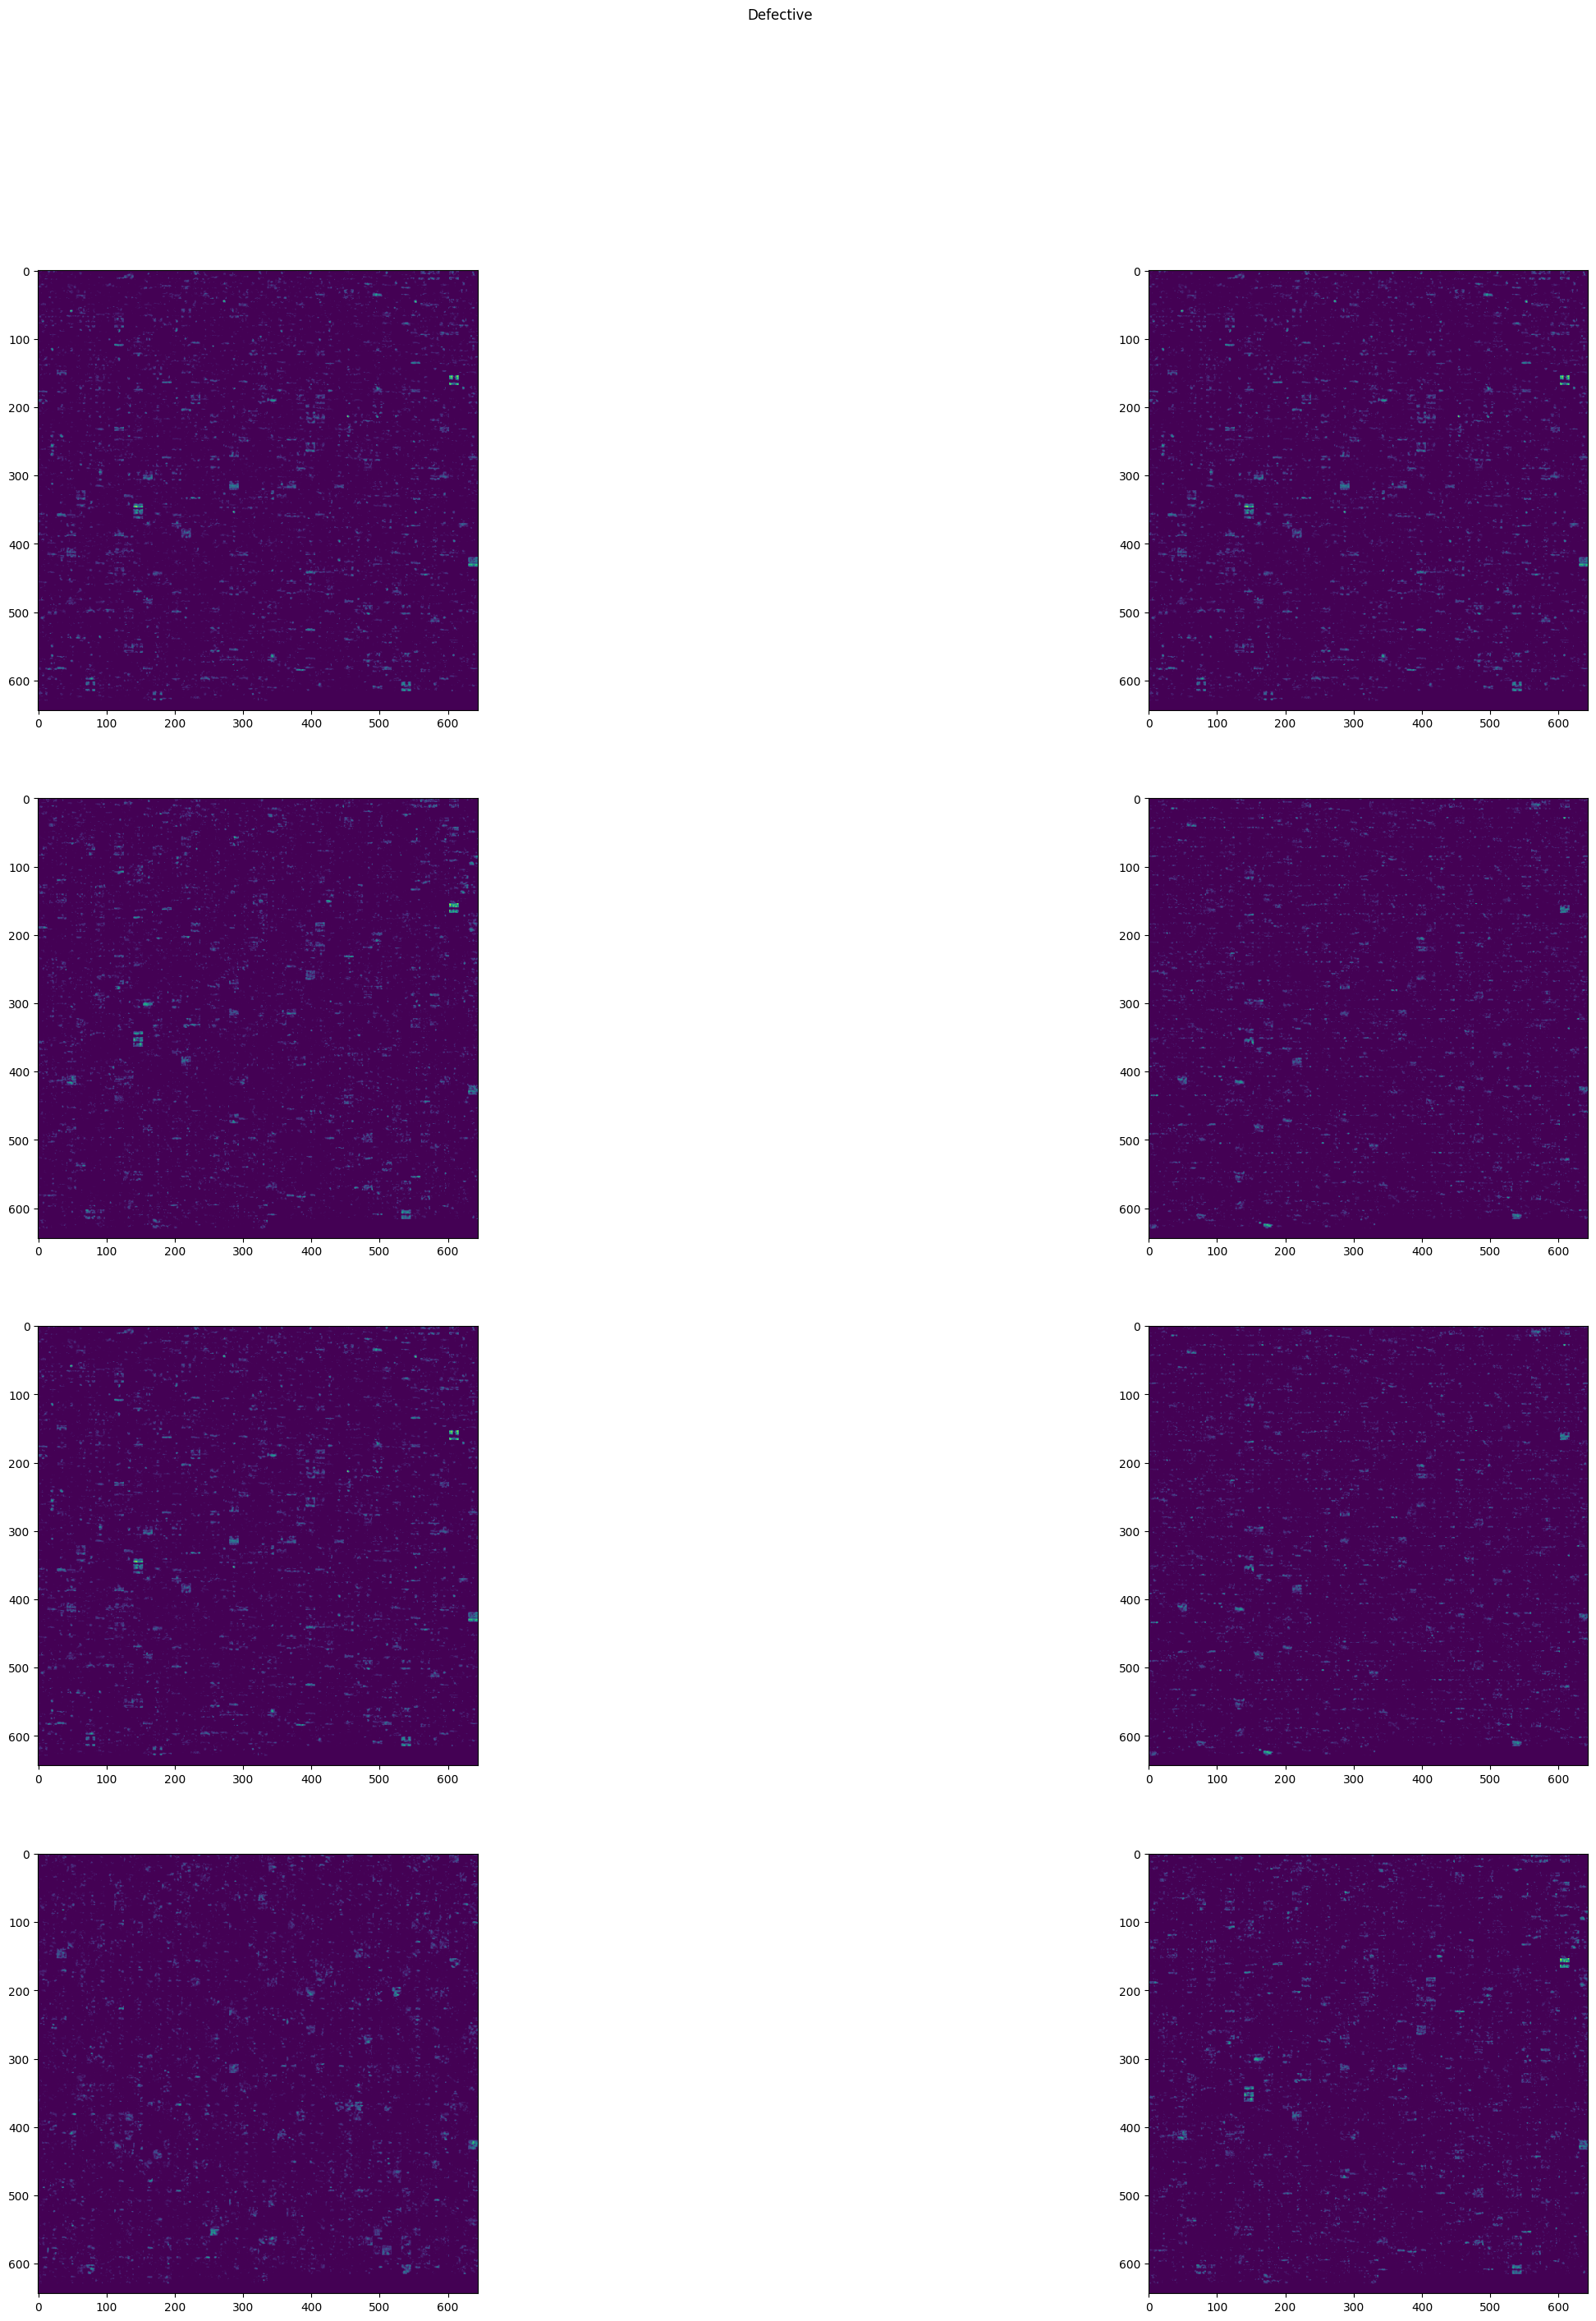

In [43]:
activations_model(model_resnet50, test_df_defective, "Defective", preprocess_input, [model_resnet50.layers[-3].name])

In [44]:
gc.collect()

75160

In [45]:
model_resnet50.save('./model_resnet50.h5')

In [46]:
model_resnet50.save('/content/drive/MyDrive/model_resnet50.h5')

1/1 [==============================] - 1s 653ms/step
[[0.00407064]]
This Railway track has fault


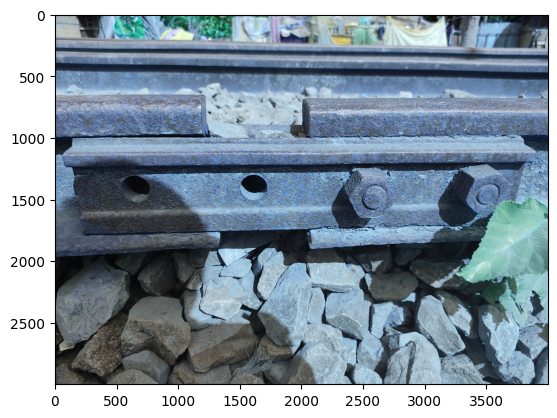

In [49]:
import cv2
import numpy as np
img = cv2.imread('/content/drive/MyDrive/Railway Track fault detection/Test/Defective/IMG_20201114_102222.jpg')
plt.imshow(img)
img = cv2.resize(img,(448,448))
img = np.reshape(img,[1,448,448,3])

classes = model_resnet50.predict(img)

print(classes)
if classes>0.5:
    print("This Railway track has no fault")
else:
    print("This Railway track has fault")

1/1 [==============================] - 1s 648ms/step
[[0.01129498]]
This Railway track has fault


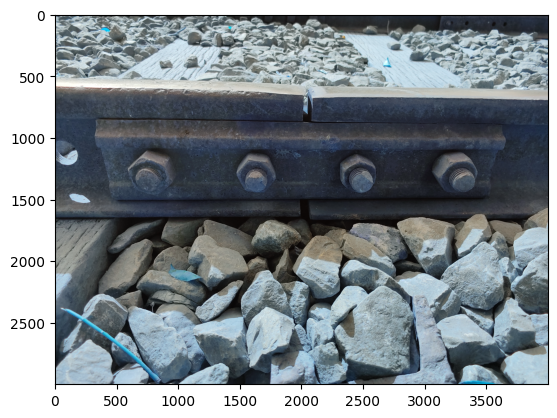

In [48]:
import cv2
import numpy as np
img = cv2.imread('/content/drive/MyDrive/Railway Track fault detection/Test/Non defective/IMG_20201114_101756.jpg')
plt.imshow(img)
img = cv2.resize(img,(448,448))
img = np.reshape(img,[1,448,448,3])

classes = model_resnet50.predict(img)

print(classes)
if classes>0.5:
    print("This Railway track has no fault")
else:
    print("This Railway track has fault")

1/1 [==============================] - 2s 2s/step
[[0.6380223]]
This Railway track has no fault


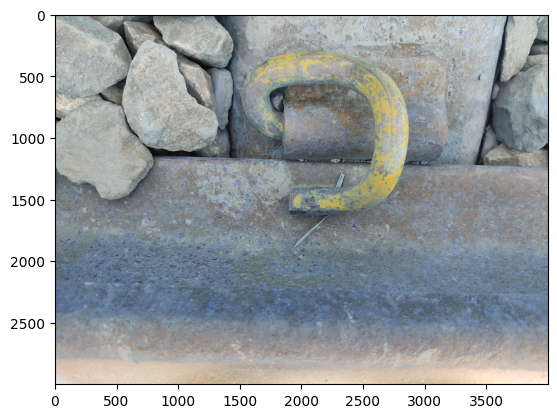

In [51]:
from keras.models import Model
from keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import numpy as np
img = cv2.imread('/content/drive/MyDrive/Railway Track fault detection/Test/Non defective/IMG_20201114_102945.jpg')
plt.imshow(img)
img = cv2.resize(img,(448,448))
img = np.reshape(img,[1,448,448,3])
model_test = load_model('/content/drive/MyDrive/model_resnet50.h5')
classes = model_test.predict(img)

print(classes)
if classes>0.5:
    print("This Railway track has no fault")
else:
    print("This Railway track has fault")